In [1]:
pip show elasticsearch

Name: elasticsearchNote: you may need to restart the kernel to use updated packages.

Version: 7.6.0
Summary: Python client for Elasticsearch
Home-page: https://github.com/elastic/elasticsearch-py
Author: Honza Král, Nick Lang
Author-email: honza.kral@gmail.com, nick@nicklang.com
License: Apache-2.0
Location: c:\users\mehta\anaconda3\envs\py37\lib\site-packages
Requires: urllib3
Required-by: 


In [2]:
from elasticsearch import Elasticsearch

In [3]:
es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme': 'http'}])

In [4]:
es.info()

{'name': 'DESKTOP-Q5T87SF',
 'cluster_name': 'elasticsearch',
 'cluster_uuid': 'muA08ndyRfWSDgYcA-aCaQ',
 'version': {'number': '7.6.2',
  'build_flavor': 'default',
  'build_type': 'zip',
  'build_hash': 'ef48eb35cf30adf4db14086e8aabd07ef6fb113f',
  'build_date': '2020-03-26T06:34:37.794943Z',
  'build_snapshot': False,
  'lucene_version': '8.4.0',
  'minimum_wire_compatibility_version': '6.8.0',
  'minimum_index_compatibility_version': '6.0.0-beta1'},
 'tagline': 'You Know, for Search'}

In [5]:
!python --version

Python 3.7.16


In [6]:
import sys
print(sys.version)


3.7.16 (default, Jan 17 2023, 16:06:28) [MSC v.1916 64 bit (AMD64)]


In [7]:
import pyspark
print(pyspark.__version__)

2.4.5


In [ ]:
pip install pyspark==2.4.5

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

In [9]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .appName("Elasticsearch Spark Connector") \
        .config("spark.driver.extraClassPath", "C:/Users/MEHTA/Desktop/Recommend_System/elasticsearch-hadoop-7.6.2/dist/elasticsearch-spark-20_2.11-7.6.2.jar") \
        .config("spark.executor.extraClassPath", "C:/Users/MEHTA/Desktop/Recommend_System/elasticsearch-hadoop-7.6.2/dist/elasticsearch-spark-20_2.11-7.6.2.jar") \
        .config("spark.es.nodes", "localhost") \
        .config("spark.es.port", "9200") \
        .config("spark.es.nodes.wan.only", "true") \
        .getOrCreate()



In [10]:
from IPython.display import Image, HTML, display
spark

In [11]:
PATH_TO_DATA = "C:/Users/MEHTA/Desktop/Recommend_System/ml-latest-small"
ratings = spark.read.csv(PATH_TO_DATA + "/ratings.csv", header=True, inferSchema=True)
ratings.cache()
print("Number of ratings: {}".format(ratings.count()))
print("Sample of ratings:")
ratings.show(5)

Number of ratings: 100836
Sample of ratings:
+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [12]:
ratings = ratings.select(
    ratings.userId, ratings.movieId, ratings.rating, (ratings.timestamp.cast("long") * 1000).alias("timestamp"))
ratings.show(5)

+------+-------+------+------------+
|userId|movieId|rating|   timestamp|
+------+-------+------+------------+
|     1|      1|   4.0|964982703000|
|     1|      3|   4.0|964981247000|
|     1|      6|   4.0|964982224000|
|     1|     47|   5.0|964983815000|
|     1|     50|   5.0|964982931000|
+------+-------+------+------------+
only showing top 5 rows



In [13]:
raw_movies = spark.read.csv(PATH_TO_DATA + "/movies.csv", header=True, inferSchema=True)
print("Raw movie data:")
raw_movies.show(5, truncate=False)

Raw movie data:
+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows



In [14]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *
extract_genres = udf(lambda x: x.lower().split("|"), ArrayType(StringType()))
raw_movies.select("movieId", "title", extract_genres("genres").alias("genres")).show(5, False)

+-------+----------------------------------+-------------------------------------------------+
|movieId|title                             |genres                                           |
+-------+----------------------------------+-------------------------------------------------+
|1      |Toy Story (1995)                  |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji (1995)                    |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men (1995)           |[comedy, romance]                                |
|4      |Waiting to Exhale (1995)          |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II (1995)|[comedy]                                         |
+-------+----------------------------------+-------------------------------------------------+
only showing top 5 rows



In [70]:
import re
def extract_year_fn(title):
    result = re.search("\(\d{4}\)", title)
    try:
        if result:
            group = result.group()
            year = group[1:-1]
            start_pos = result.start()
            title = title[:start_pos-1]
            return (title, year)
        else:
            return (title, 1970)
    except:
        print(title)

extract_year = udf(extract_year_fn,\
                   StructType([StructField("title", StringType(), True),\
                               StructField("release_date", StringType(), True)]))
    

s = "Pacific Rim: Uprising (2018)"
extract_year_fn(s)

('Pacific Rim: Uprising', '2018')

In [16]:
movies = raw_movies.select(
    "movieId", extract_year("title").title.alias("title"),\
    extract_year("title").release_date.alias("release_date"),\
    extract_genres("genres").alias("genres"))
print("Cleaned movie data:")
movies.show(5, truncate=False)

Cleaned movie data:
+-------+---------------------------+------------+-------------------------------------------------+
|movieId|title                      |release_date|genres                                           |
+-------+---------------------------+------------+-------------------------------------------------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |
+-------+---------------------------+------------+-------------------------------------------------+
only showing top 5 rows



In [17]:
link_data = spark.read.csv(PATH_TO_DATA + "/links.csv", header=True, inferSchema=True)
movie_data = movies.join(link_data, movies.movieId == link_data.movieId)\
    .select(movies.movieId, movies.title, movies.release_date, movies.genres, link_data.tmdbId)
num_movies = movie_data.count()
print("Cleaned movie data with tmdbId links:")
movie_data.show(5, truncate=False)

Cleaned movie data with tmdbId links:
+-------+---------------------------+------------+-------------------------------------------------+------+
|movieId|title                      |release_date|genres                                           |tmdbId|
+-------+---------------------------+------------+-------------------------------------------------+------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|862   |
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |8844  |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |15602 |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |31357 |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |11862 |
+-------+---------------------------+------------+------------------------------------------------

In [19]:
pip install matplotlib

     ---------------------------------------- 7.2/7.2 MB 4.6 MB/s eta 0:00:00
     ---------------------------------------- 54.9/54.9 kB ? eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 5.7 MB/s eta 0:00:00
     -------------------------------------- 965.4/965.4 kB 5.6 MB/s eta 0:00:00
     ---------------------------------------- 98.3/98.3 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


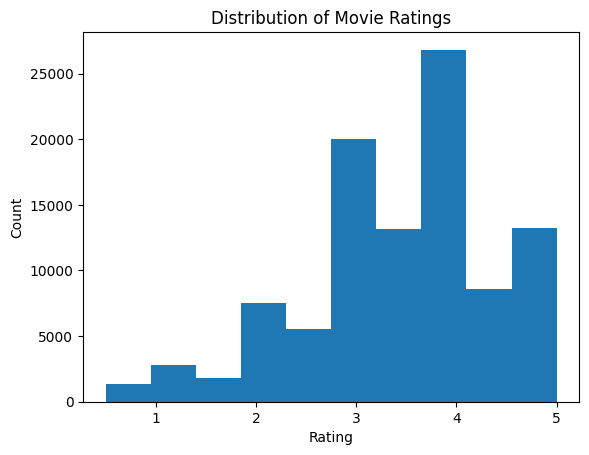

In [20]:
import matplotlib.pyplot as plt
import numpy as np

ratings_array = np.array(ratings.select("rating").collect())

plt.hist(ratings_array, bins=10)
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


In [21]:
from pyspark.sql.functions import mean, stddev

mean_rating = ratings.select(mean("rating")).collect()[0][0]
stddev_rating = ratings.select(stddev("rating")).collect()[0][0]

print(f"Mean rating: {mean_rating:.2f}")
print(f"Standard deviation of ratings: {stddev_rating:.2f}")

Mean rating: 3.50
Standard deviation of ratings: 1.04


In [23]:
pip install scipy

     ---------------------------------------- 34.1/34.1 MB 4.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [24]:
from pyspark.sql.functions import col
from scipy.stats import pearsonr

# Get the ratings for both movies
movie1_ratings = ratings.filter("movieId = 1").select(col("userId"), col("rating").alias("rating1"))
movie2_ratings = ratings.filter("movieId = 2").select(col("userId"), col("rating").alias("rating2"))

combined_ratings = movie1_ratings.join(movie2_ratings, "userId", "inner")

movie1_ratings = combined_ratings.select("rating1").rdd.flatMap(lambda x: x).collect()
movie2_ratings = combined_ratings.select("rating2").rdd.flatMap(lambda x: x).collect()

correlation_coefficient, _ = pearsonr(movie1_ratings, movie2_ratings)
print(f"Pearson correlation coefficient between movies 1 and 2: {correlation_coefficient:.2f}")


Pearson correlation coefficient between movies 1 and 2: 0.33


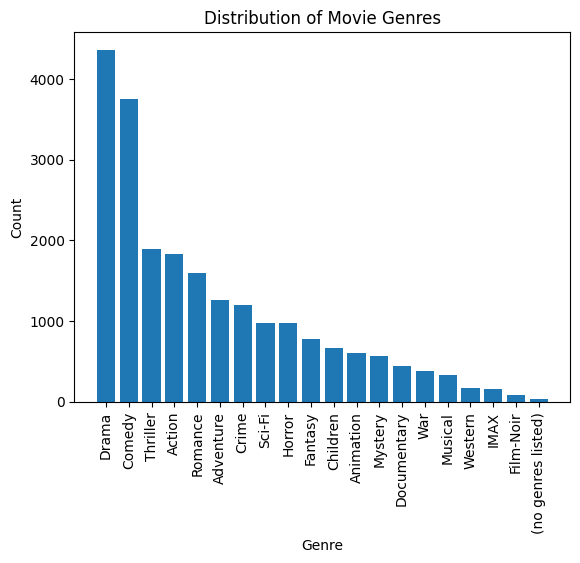

In [25]:
import matplotlib.pyplot as plt

genres = raw_movies.select("genres").rdd.flatMap(lambda x: x[0].split("|"))

genre_counts = genres.countByValue()

sorted_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)

genres = [g[0] for g in sorted_genres]
counts = [g[1] for g in sorted_genres]

plt.bar(genres, counts)
plt.title("Distribution of Movie Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()


In [26]:
from pyspark.sql.functions import count, desc, avg, col

ratings_with_movies = ratings.join(movies, "movieId", "inner")

genre_columns = [movies[col.name].alias("genre") for col in movies.schema if col.name == "genres"]

genres = ratings_with_movies.select(genre_columns + ["rating"])

genre_stats = genres.groupBy("genre").agg(count("rating").alias("count"), avg("rating").alias("avg_rating"))

sorted_genres = genre_stats.orderBy(desc("count"))

sorted_genres.show()

+--------------------+-----+------------------+
|               genre|count|        avg_rating|
+--------------------+-----+------------------+
|            [comedy]| 7196| 3.197887715397443|
|             [drama]| 6291| 3.688841201716738|
|   [comedy, romance]| 3967|3.3200151247794305|
|[comedy, drama, r...| 3000|            3.5505|
|     [comedy, drama]| 2851| 3.517186951946685|
|    [drama, romance]| 2838| 3.661909795630726|
|[action, adventur...| 2361|3.5501905972045744|
|      [crime, drama]| 2315|               4.0|
|[action, crime, t...| 1554| 3.492599742599743|
|[action, adventur...| 1455| 3.365635738831615|
|[action, adventur...| 1446|3.4889349930843707|
|   [drama, thriller]| 1365| 3.378021978021978|
|[action, sci-fi, ...| 1195|3.5581589958158997|
|     [comedy, crime]| 1171|3.4321093082835183|
|[crime, drama, th...| 1119|  3.73503127792672|
|        [drama, war]| 1044| 3.968390804597701|
|[action, drama, war]| 1034|3.9308510638297873|
|[action, crime, d...| 1007| 3.724428997

In [27]:
most_watched_genre = sorted_genres.first()["genre"]
print(f"The most watched genre is {most_watched_genre}")

The most watched genre is ['comedy']


In [28]:
from pyspark.sql.functions import count

ratings_per_user = ratings.groupBy("userId").agg(count("rating").alias("num_ratings"))
ratings_per_user.show()

+------+-----------+
|userId|num_ratings|
+------+-----------+
|   148|         48|
|   463|         33|
|   471|         28|
|   496|         29|
|   243|         36|
|   392|         25|
|   540|         42|
|    31|         50|
|   516|         26|
|    85|         34|
|   137|        141|
|   251|         23|
|   451|         34|
|   580|        436|
|    65|         34|
|   458|         59|
|    53|         20|
|   255|         44|
|   481|         31|
|   588|         56|
+------+-----------+
only showing top 20 rows



In [29]:
ratings_per_movie = ratings.groupBy("movieId").agg(count("rating").alias("num_ratings"))
ratings_per_movie.show()

+-------+-----------+
|movieId|num_ratings|
+-------+-----------+
|   1580|        165|
|   2366|         25|
|   3175|         75|
|   1088|         42|
|  32460|          4|
|  44022|         23|
|  96488|          4|
|   1238|          9|
|   1342|         11|
|   1591|         26|
|   1645|         51|
|   4519|          9|
|   2142|         10|
|    471|         40|
|   3997|         12|
|    833|          6|
|   3918|          9|
|   7982|          4|
|   1959|         15|
|  68135|         10|
+-------+-----------+
only showing top 20 rows



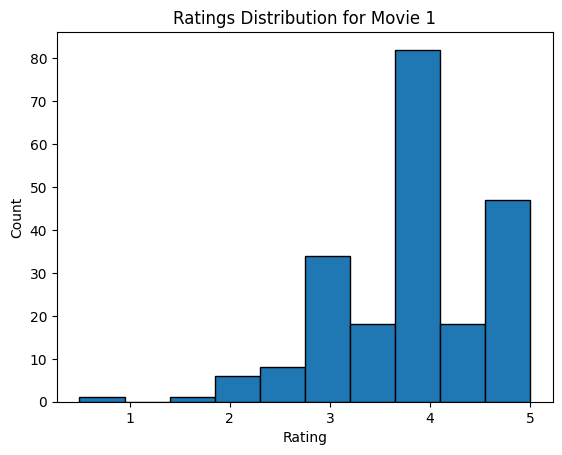

In [30]:
import matplotlib.pyplot as plt

movie_id = 1

movie_ratings = ratings.filter(ratings.movieId == movie_id).select("rating").rdd.flatMap(lambda x: x)

plt.hist(movie_ratings.collect(), bins=10, edgecolor='black')
plt.title(f"Ratings Distribution for Movie {movie_id}")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

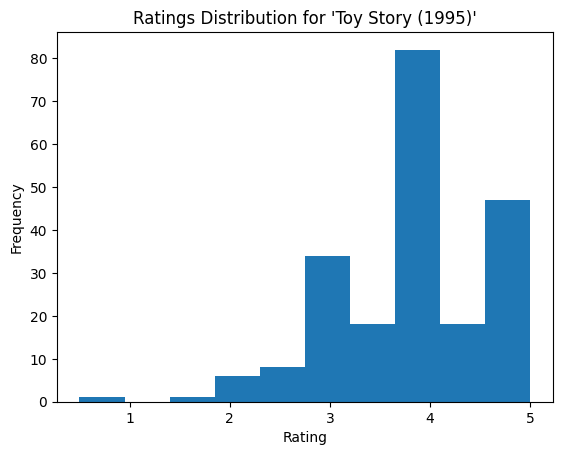

In [31]:
import matplotlib.pyplot as plt

ratings_with_movie_title = ratings_per_movie.join(movies, "movieId", "inner").select("title", "num_ratings")

movie_title = "Toy Story (1995)"
ratings_for_movie = ratings.filter(ratings.movieId == 1).select("rating").rdd.flatMap(lambda x: x).collect()

plt.hist(ratings_for_movie, bins=10)
plt.title(f"Ratings Distribution for '{movie_title}'")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

In [32]:

movies_with_ratings = movies.join(ratings, on='movieId')

average_ratings = movies_with_ratings.groupBy('title').agg({'rating': 'avg'})

average_ratings.show()

+--------------------+------------------+
|               title|       avg(rating)|
+--------------------+------------------+
|  Living in Oblivion|4.3076923076923075|
|Thomas Crown Affa...| 3.690909090909091|
|                Nell|            3.3375|
|        Aviator, The|3.5285714285714285|
|Penguins of Madag...|               3.7|
|        Miracle Mile|               3.5|
|Dog Days (Hundstage)|               3.0|
|Escape from the P...|               3.0|
|         Deep Rising|               2.3|
|       Sugar & Spice|2.7142857142857144|
|   Failure to Launch|              3.25|
|       Big Year, The|              3.75|
|       Boy Eats Girl|               5.0|
|          Middle Men|              3.25|
|Honey, We Shrunk ...|               3.5|
|Fright Night Part II|               2.0|
|Man with the Movi...|3.3333333333333335|
|            Dogville|             4.025|
|Chorus, The (Chor...| 3.909090909090909|
|Popstar: Never St...|              2.75|
+--------------------+------------

In [35]:
pip install seaborn

     -------------------------------------- 293.3/293.3 kB 3.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


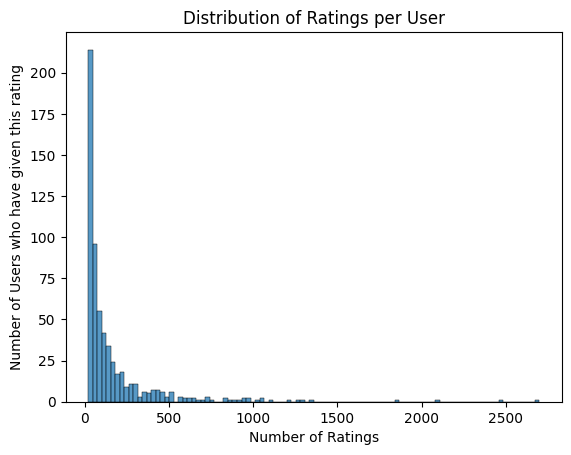

In [36]:
import seaborn as sns
ratings_per_user = ratings.groupBy("userId").agg(count("rating").alias("num_ratings"))

ratings_per_user_pd = ratings_per_user.select("num_ratings").toPandas()

sns.histplot(ratings_per_user_pd["num_ratings"], bins=100, kde=False)
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users who have given this rating")
plt.title("Distribution of Ratings per User")
plt.show()

In [19]:
import tmdbsimple as tmdb

Successfully imported tmdbsimple!


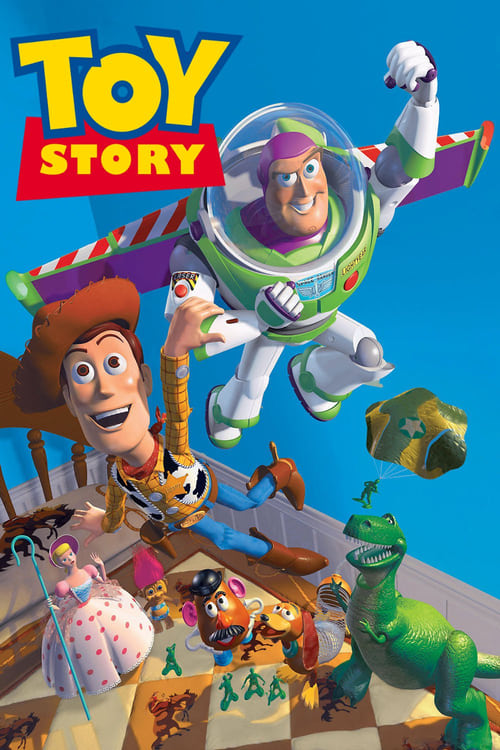

In [40]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

try:
    import tmdbsimple as tmdb
    import json
    from requests.exceptions import HTTPError
    tmdb.API_KEY = '********************************'
    print("Successfully imported tmdbsimple!")
    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    movie_id = movie_data.first().tmdbId
    movie_info = tmdb.Movies(movie_id).info()
    movie_poster_url = IMAGE_URL + movie_info['poster_path']
    display(Image(movie_poster_url, width=200))
except ImportError:
    print("Cannot import tmdbsimple as it is not installed, no movie posters will be displayed!")
except HTTPError as e:
    if e.response.status_code == 401:
        j = json.loads(e.response.text)
        print("TMdb API call failed: {}".format(j['status_message']))


In [21]:
VECTOR_DIM = 20

create_ratings = {
  
    "mappings": {
        "properties": {
            "timestamp": {
                "type": "date"
            },
            "userId": {
                "type": "integer"
            },
            "movieId": {
                "type": "integer"
            },
            "rating": {
                "type": "double"
            }
        }  
    }
}

create_users = {
   
    "mappings": {
        "properties": {
            "userId": {
                "type": "integer"
            },
          
            "model_factor": {
                "type": "dense_vector",
                "dims" : VECTOR_DIM
            },
            "model_version": {
                "type": "keyword"
            },
            "model_timestamp": {
                "type": "date"
            }
        }
    }
}

create_movies = {
 
    "mappings": {
        "properties": {
            "movieId": {
                "type": "integer"
            },
            "tmdbId": {
                "type": "keyword"
            },
            "genres": {
                "type": "keyword"
            },
            "release_date": {
                "type": "date",
                "format": "year"
            },
           
            "model_factor": {
                "type": "dense_vector",
                "dims" : VECTOR_DIM
            },
            "model_version": {
                "type": "keyword"
            },
            "model_timestamp": {
                "type": "date"
            }          
        }
    }
}

res_ratings = es.indices.create(index="ratings", body=create_ratings)
res_users = es.indices.create(index="users", body=create_users)
res_movies = es.indices.create(index="movies", body=create_movies)

print("Created indices:")
print(res_ratings)
print(res_users)
print(res_movies)

RequestError: RequestError(400, 'resource_already_exists_exception', 'index [ratings/DLA1aiEyQUS6qwi1sOSC7A] already exists')

RequestError: RequestError(400, 'resource_already_exists_exception', 'index [ratings/DLA1aiEyQUS6qwi1sOSC7A] already exists')

In [22]:

ratings.write.format("es").save("ratings")

num_ratings_es = es.count(index="ratings")['count']
num_ratings_df = ratings.count()

print("Dataframe count: {}".format(num_ratings_df))
print("ES index count:  {}".format(num_ratings_es))

Dataframe count: 100836
ES index count:  100836
Dataframe count: 100836
ES index count:  100836


In [23]:
es.search(index="ratings", q="*", size=3)

{'took': 202,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 10000, 'relation': 'gte'},
  'max_score': 1.0,
  'hits': [{'_index': 'ratings',
    '_type': '_doc',
    '_id': 'wUPQtYYBINN4H1NwH19O',
    '_score': 1.0,
    '_source': {'userId': 1,
     'movieId': 1,
     'rating': 4.0,
     'timestamp': 964982703000}},
   {'_index': 'ratings',
    '_type': '_doc',
    '_id': 'wkPQtYYBINN4H1NwH19O',
    '_score': 1.0,
    '_source': {'userId': 1,
     'movieId': 3,
     'rating': 4.0,
     'timestamp': 964981247000}},
   {'_index': 'ratings',
    '_type': '_doc',
    '_id': 'w0PQtYYBINN4H1NwH19O',
    '_score': 1.0,
    '_source': {'userId': 1,
     'movieId': 6,
     'rating': 4.0,
     'timestamp': 964982224000}}]}}

{'took': 202,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 10000, 'relation': 'gte'},
  'max_score': 1.0,
  'hits': [{'_index': 'ratings',
    '_type': '_doc',
    '_id': 'wUPQtYYBINN4H1NwH19O',
    '_score': 1.0,
    '_source': {'userId': 1,
     'movieId': 1,
     'rating': 4.0,
     'timestamp': 964982703000}},
   {'_index': 'ratings',
    '_type': '_doc',
    '_id': 'wkPQtYYBINN4H1NwH19O',
    '_score': 1.0,
    '_source': {'userId': 1,
     'movieId': 3,
     'rating': 4.0,
     'timestamp': 964981247000}},
   {'_index': 'ratings',
    '_type': '_doc',
    '_id': 'w0PQtYYBINN4H1NwH19O',
    '_score': 1.0,
    '_source': {'userId': 1,
     'movieId': 6,
     'rating': 4.0,
     'timestamp': 964982224000}}]}}

In [24]:
es.count(index="ratings", q="timestamp:[2018-01-01 TO 2018-02-01]")

{'count': 952,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}}

{'count': 952,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}}

In [25]:
movie_data.write.format("es").option("es.mapping.id", "movieId").save("movies")
num_movies_df = movie_data.count()
num_movies_es = es.count(index="movies")['count']

print("Movie DF count: {}".format(num_movies_df))
print("ES index count: {}".format(num_movies_es))

Movie DF count: 9742
ES index count: 9742
Movie DF count: 9742
ES index count: 9742


In [26]:
es.search(index="movies", q="title:matrix", size=3)

{'took': 32,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 3, 'relation': 'eq'},
  'max_score': 9.46188,
  'hits': [{'_index': 'movies',
    '_type': '_doc',
    '_id': '2571',
    '_score': 9.46188,
    '_source': {'movieId': 2571,
     'title': 'Matrix, The',
     'release_date': '1999',
     'genres': ['action', 'sci-fi', 'thriller'],
     'tmdbId': 603}},
   {'_index': 'movies',
    '_type': '_doc',
    '_id': '6365',
    '_score': 8.245362,
    '_source': {'movieId': 6365,
     'title': 'Matrix Reloaded, The',
     'release_date': '2003',
     'genres': ['action', 'adventure', 'sci-fi', 'thriller', 'imax'],
     'tmdbId': 604}},
   {'_index': 'movies',
    '_type': '_doc',
    '_id': '6934',
    '_score': 8.245362,
    '_source': {'movieId': 6934,
     'title': 'Matrix Revolutions, The',
     'release_date': '2003',
     'genres': ['action', 'adventure', 'sci-fi', 'thriller', 'imax'],
     'tmdbId': 605}}]}}

{'took': 32,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 3, 'relation': 'eq'},
  'max_score': 9.46188,
  'hits': [{'_index': 'movies',
    '_type': '_doc',
    '_id': '2571',
    '_score': 9.46188,
    '_source': {'movieId': 2571,
     'title': 'Matrix, The',
     'release_date': '1999',
     'genres': ['action', 'sci-fi', 'thriller'],
     'tmdbId': 603}},
   {'_index': 'movies',
    '_type': '_doc',
    '_id': '6365',
    '_score': 8.245362,
    '_source': {'movieId': 6365,
     'title': 'Matrix Reloaded, The',
     'release_date': '2003',
     'genres': ['action', 'adventure', 'sci-fi', 'thriller', 'imax'],
     'tmdbId': 604}},
   {'_index': 'movies',
    '_type': '_doc',
    '_id': '6934',
    '_score': 8.245362,
    '_source': {'movieId': 6934,
     'title': 'Matrix Revolutions, The',
     'release_date': '2003',
     'genres': ['action', 'adventure', 'sci-fi', 'thriller', 'imax'],
     'tmdbId': 605}}]}}

In [27]:
ratings_from_es = spark.read.format("es").load("ratings")
ratings_from_es.show(5)

+-------+------+-------------------+------+
|movieId|rating|          timestamp|userId|
+-------+------+-------------------+------+
|      1|   4.0|2000-07-31 00:15:03|     1|
|      3|   4.0|2000-07-30 23:50:47|     1|
|      6|   4.0|2000-07-31 00:07:04|     1|
|     47|   5.0|2000-07-31 00:33:35|     1|
|     50|   5.0|2000-07-31 00:18:51|     1|
+-------+------+-------------------+------+
only showing top 5 rows

+-------+------+-------------------+------+
|movieId|rating|          timestamp|userId|
+-------+------+-------------------+------+
|      1|   4.0|2000-07-31 00:15:03|     1|
|      3|   4.0|2000-07-30 23:50:47|     1|
|      6|   4.0|2000-07-31 00:07:04|     1|
|     47|   5.0|2000-07-31 00:33:35|     1|
|     50|   5.0|2000-07-31 00:18:51|     1|
+-------+------+-------------------+------+
only showing top 5 rows



In [29]:
pip install numpy

     ---------------------------------------- 14.0/14.0 MB 4.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 14.0/14.0 MB 4.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [30]:
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", regParam=0.02, rank=VECTOR_DIM, seed=54)
model = als.fit(ratings_from_es)
model.userFactors.show(5)
model.itemFactors.show(5)

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.13299428, 0.42...|
| 20|[0.2196542, -0.28...|
| 30|[-0.58235997, 0.1...|
| 40|[0.31613937, -0.2...|
| 50|[0.3011615, 0.112...|
+---+--------------------+
only showing top 5 rows

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.6092093, 0.570...|
| 20|[0.12555358, -0.2...|
| 30|[0.9184103, 0.465...|
| 40|[0.40230548, 0.53...|
| 50|[0.56450856, 0.10...|
+---+--------------------+
only showing top 5 rows

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.13299428, 0.42...|
| 20|[0.2196542, -0.28...|
| 30|[-0.58235997, 0.1...|
| 40|[0.31613937, -0.2...|
| 50|[0.3011615, 0.112...|
+---+--------------------+
only showing top 5 rows

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.6092093, 0.570...|
| 20|[0.12555358, -0.2...|
| 30|[0.9184103, 0.465...|
| 40|[0.40230548, 0.53...|
| 50|[0

In [31]:
from pyspark.sql.functions import lit, current_timestamp, unix_timestamp
ver = model.uid
ts = unix_timestamp(current_timestamp())
movie_vectors = model.itemFactors.select("id",\
                                         col("features").alias("model_factor"),\
                                         lit(ver).alias("model_version"),\
                                         ts.alias("model_timestamp"))
movie_vectors.show(5)
user_vectors = model.userFactors.select("id",\
                                        col("features").alias("model_factor"),\
                                        lit(ver).alias("model_version"),\
                                        ts.alias("model_timestamp"))
user_vectors.show(5)

+---+--------------------+----------------+---------------+
| id|        model_factor|   model_version|model_timestamp|
+---+--------------------+----------------+---------------+
| 10|[0.6092093, 0.570...|ALS_e74a5825b52e|     1678087823|
| 20|[0.12555358, -0.2...|ALS_e74a5825b52e|     1678087823|
| 30|[0.9184103, 0.465...|ALS_e74a5825b52e|     1678087823|
| 40|[0.40230548, 0.53...|ALS_e74a5825b52e|     1678087823|
| 50|[0.56450856, 0.10...|ALS_e74a5825b52e|     1678087823|
+---+--------------------+----------------+---------------+
only showing top 5 rows

+---+--------------------+----------------+---------------+
| id|        model_factor|   model_version|model_timestamp|
+---+--------------------+----------------+---------------+
| 10|[0.6092093, 0.570...|ALS_e74a5825b52e|     1678087823|
| 20|[0.12555358, -0.2...|ALS_e74a5825b52e|     1678087823|
| 30|[0.9184103, 0.465...|ALS_e74a5825b52e|     1678087823|
| 40|[0.40230548, 0.53...|ALS_e74a5825b52e|     1678087823|
| 50|[0.5645085

In [32]:
movie_vectors.write.format("es") \
    .option("es.mapping.id", "id") \
    .option("es.write.operation", "update") \
    .save("movies", mode="append")

In [33]:
user_vectors.write.format("es") \
    .option("es.mapping.id", "id") \
    .option("es.write.operation", "index") \
    .save("users", mode="append")

In [34]:
es.search(index="movies", q="force awakens")['hits']['hits'][0]

{'_index': 'movies',
 '_type': '_doc',
 '_id': '122886',
 '_score': 10.524785,
 '_source': {'movieId': 122886,
  'title': 'Star Wars: Episode VII - The Force Awakens',
  'release_date': '2015',
  'genres': ['action', 'adventure', 'fantasy', 'sci-fi', 'imax'],
  'tmdbId': 140607,
  'model_timestamp': 1678087833,
  'model_version': 'ALS_e74a5825b52e',
  'model_factor': [0.18812202,
   0.7076669,
   -1.3437241,
   -0.3083917,
   0.31944987,
   0.45389917,
   -0.8027336,
   -0.66270983,
   1.2934446,
   -0.12376652,
   0.5889607,
   -0.12555946,
   -1.1881688,
   0.60742664,
   1.0457083,
   0.564867,
   0.89669603,
   1.1521518,
   -0.39917782,
   -2.687924],
  'id': 122886}}

{'_index': 'movies',
 '_type': '_doc',
 '_id': '122886',
 '_score': 10.524785,
 '_source': {'movieId': 122886,
  'title': 'Star Wars: Episode VII - The Force Awakens',
  'release_date': '2015',
  'genres': ['action', 'adventure', 'fantasy', 'sci-fi', 'imax'],
  'tmdbId': 140607,
  'model_timestamp': 1678087833,
  'model_version': 'ALS_e74a5825b52e',
  'model_factor': [0.18812202,
   0.7076669,
   -1.3437241,
   -0.3083917,
   0.31944987,
   0.45389917,
   -0.8027336,
   -0.66270983,
   1.2934446,
   -0.12376652,
   0.5889607,
   -0.12555946,
   -1.1881688,
   0.60742664,
   1.0457083,
   0.564867,
   0.89669603,
   1.1521518,
   -0.39917782,
   -2.687924],
  'id': 122886}}

In [41]:
from IPython.display import Image, HTML, display

def get_poster_url(id):
    
    
    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    try:
        import tmdbsimple as tmdb
        from tmdbsimple import APIKeyError
        try:
            movie = tmdb.Movies(id).info()
            poster_url = IMAGE_URL + movie['poster_path'] if 'poster_path' in movie and movie['poster_path'] is not None else ""
            return poster_url
        except APIKeyError as ae:
            return "KEY_ERR"
    except Exception as me:
        return "NA"
    
    
def vector_query(query_vec, vector_field, q="*", cosine=False):
   
    
    if cosine:
        score_fn = "doc['{v}'].size() == 0 ? 0 : cosineSimilarity(params.vector, '{v}') + 1.0"
    else:
        score_fn = "doc['{v}'].size() == 0 ? 0 : sigmoid(1, Math.E, -dotProduct(params.vector, '{v}'))"
       
    score_fn = score_fn.format(v=vector_field, fn=score_fn)
    
    return {
    "query": {
        "script_score": {
            "query" : { 
                "query_string": {
                    "query": q
                }
            },
            "script": {
                "source": score_fn,
                "params": {
                    "vector": query_vec
                }
            }
        }
    }
}


def get_similar(the_id, q="*", num=10, index="movies", vector_field='model_factor'):
   
    response = es.get(index=index, id=the_id)
    src = response['_source']
    if vector_field in src:
        query_vec = src[vector_field]
        q = vector_query(query_vec, vector_field, q=q, cosine=True)
        results = es.search(index=index, body=q)
        hits = results['hits']['hits']
        return src, hits[1:num+1]
    
    
def get_user_recs(the_id, q="*", num=10, users="users", movies="movies", vector_field='model_factor'):
    
    response = es.get(index=users, id=the_id)
    src = response['_source']
    if vector_field in src:
        query_vec = src[vector_field]
        q = vector_query(query_vec, vector_field, q=q, cosine=False)
        results = es.search(index=movies, body=q)
        hits = results['hits']['hits']
        return src, hits[:num]

def get_movies_for_user(the_id, num=10, ratings="ratings", movies="movies"):
   
    response = es.search(index=ratings, q="userId:{}".format(the_id), size=num, sort=["rating:desc"])
    hits = response['hits']['hits']
    ids = [h['_source']['movieId'] for h in hits]
    movies = es.mget(body={"ids": ids}, index=movies, _source_includes=['tmdbId', 'title'])
    movies_hits = movies['docs']
    tmdbids = [h['_source'] for h in movies_hits]
    return tmdbids

            
def display_user_recs(the_id, q="*", num=10, num_last=10, users="users", movies="movies", ratings="ratings"):
    user, recs = get_user_recs(the_id, q, num, users, movies)
    user_movies = get_movies_for_user(the_id, num_last, ratings, movies)
    
    first_movie = user_movies[0]
    first_im_url = get_poster_url(first_movie['tmdbId'])
    if first_im_url == "NA":
        display(HTML("<i>Cannot import tmdbsimple. No movie posters will be displayed!</i>"))
    if first_im_url == "KEY_ERR":
        display(HTML("<i>Key error accessing TMDb API. Check your API key. No movie posters will be displayed!</i>"))
        
    
    display(HTML("<h2>Get recommended movies for user id %s</h2>" % the_id))
    display(HTML("<h4>The user has rated the following movies highly:</h4>"))
    user_html = "<table border=0>"
    i = 0
    for movie in user_movies:
        movie_im_url = get_poster_url(movie['tmdbId'])
        movie_title = movie['title']
        user_html += "<td><h5>%s</h5><img src=%s width=150></img></td>" % (movie_title, movie_im_url)
        i += 1
        if i % 5 == 0:
            user_html += "</tr><tr>"
    user_html += "</tr></table>"
    display(HTML(user_html))
   
    display(HTML("<br>"))
    display(HTML("<h2>Recommended movies:</h2>"))
    rec_html = "<table border=0>"
    i = 0
    for rec in recs:
        r_im_url = get_poster_url(rec['_source']['tmdbId'])
        r_score = rec['_score']
        r_title = rec['_source']['title']
        rec_html += "<td><h5>%s</h5><img src=%s width=150></img></td><td><h5>%2.3f</h5></td>" % (r_title, r_im_url, r_score)
        i += 1
        if i % 5 == 0:
            rec_html += "</tr><tr>"
    rec_html += "</tr></table>"
    display(HTML(rec_html))

    
def display_similar(the_id, q="*", num=10, movies="movies"):
   
    movie, recs = get_similar(the_id, q, num, movies)
    q_im_url = get_poster_url(movie['tmdbId'])
    if q_im_url == "NA":
        display(HTML("<i>Cannot import tmdbsimple. No movie posters will be displayed!</i>"))
    if q_im_url == "KEY_ERR":
        display(HTML("<i>Key error accessing TMDb API. Check your API key. No movie posters will be displayed!</i>"))
        
    display(HTML("<h2>Get similar movies for:</h2>"))
    display(HTML("<h4>%s</h4>" % movie['title']))
    if q_im_url != "NA":
        display(Image(q_im_url, width=200))
    display(HTML("<br>"))
    display(HTML("<h2>People who liked this movie also liked these:</h2>"))
    sim_html = "<table border=0>"
    i = 0
    for rec in recs:
        r_im_url = get_poster_url(rec['_source']['tmdbId'])
        r_score = rec['_score']
        r_title = rec['_source']['title']
        sim_html += "<td><h5>%s</h5><img src=%s width=150></img></td><td><h5>%2.3f</h5></td>" % (r_title, r_im_url, r_score)
        i += 1
        if i % 5 == 0:
            sim_html += "</tr><tr>"
    sim_html += "</tr></table>"
    display(HTML(sim_html))

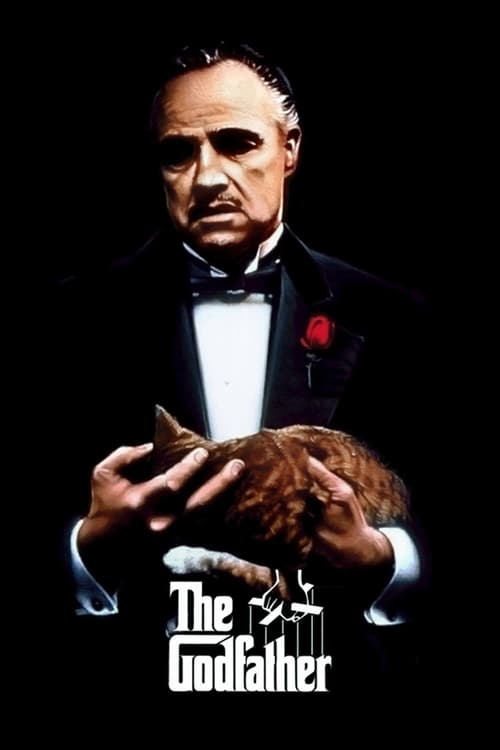

In [54]:
display_similar(858, num=3, q="title:(NOT godfather)")

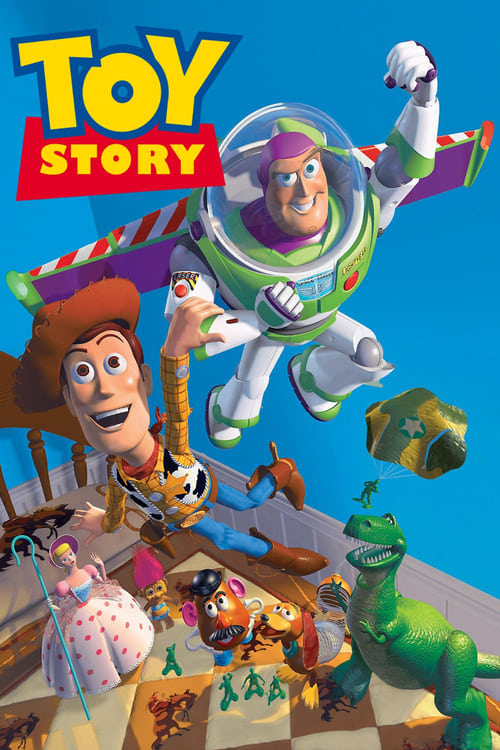

In [65]:
display_similar(1, num=3, q="genres:children")

In [69]:
display_user_recs(72, num=5, num_last=5, q="release_date:[2017 TO *]")

In [68]:
display_user_recs(157, num=3, num_last=5)